# Movies Example - Using a StratifiedSample

Author: Andreas Traut

In this example I used a dataset which contains the following columns: 

 Rank | Title | Year | Score | Metascore | Genre | Vote | Director | Runtime | **Revenue** | Description | RevCat

My aim was to predict the **Revenue** based on the other information. As there are some "NaN"-values in the column "Revenue" I did the following steps:

- I filled the "NaN"-value in column "Revenue" with Median-values,  
- then I drew a stratified sample (based on "Revenue") on the whole dataset, 
- created a pipeline to fill the "NaN"-value in other columns (e.g. "Metascore", "Score"). 
- split the dataset into a training dataset ("movies_training") and a testing dataset ("movies_test"):

([<matplotlib.patches.Wedge at 0x1fa38c75348>,
 [Text(1.0461621663333946, 0.3399186987098808, 'training data'),
  Text(-1.0461621902025062, -0.33991862524830146, 'testing data')])

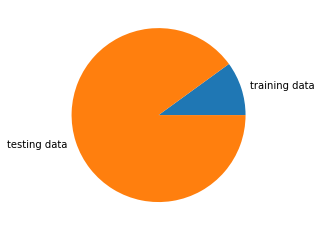

In [1]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots()
axs.pie([1000, 9000], labels=['training data', 'testing data'])

- Then I used the training dataset and fittet it with the "DecisionTreeRegressor" model
- verified with a cross-validation, how good this model/parameters are
- did a prediction on a subset of the testing dataset and did a side-by-side comparison of prediction and true value
- performed a prediction on the testing dataset and calculated the mean-squared error

In another Jupyther-Notebook I worked differently on the "Nan"-values of the "Revenue" column: instead of the median-value assumption I tried to predict these "NaN" values. 

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import OneHotEncoder  we will need this later
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [3]:
PATH = os.path.join("datasets", "movies")

In [4]:
def format_plot(ax, title, feature1, feature2):
    #ax.xaxis.set_major_formatter(plt.NullFormatter())
    #ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xlabel(feature1, color='gray')
    ax.set_ylabel(feature2, color='gray')
    ax.set_title(title, color='gray')

# Importing the data

The movies dataset can be found here: https://www.kaggle.com/isaactaylorofficial/imdb-10000-most-voted-feature-films-041118

In [5]:
def load_data(path=PATH):
    csv_path = os.path.join(path, "movies.csv")
    return pd.read_csv(csv_path)

In [6]:
movies = load_data()
movies.head()

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description
0,1,The Shawshank Redemption,1994,9.3,80.0,Drama,2011509,Frank Darabont,142,28.34,Two imprisoned men bond over a number of years...
1,2,The Dark Knight,2008,9.0,84.0,"Action, Crime, Drama",1980200,Christopher Nolan,152,534.86,When the menace known as the Joker emerges fro...
2,3,Inception,2010,8.8,74.0,"Action, Adventure, Sci-Fi",1760209,Christopher Nolan,148,292.58,A thief who steals corporate secrets through t...
3,4,Fight Club,1999,8.8,66.0,Drama,1609459,David Fincher,139,37.03,An insomniac office worker and a devil-may-car...
4,5,Pulp Fiction,1994,8.9,94.0,"Crime, Drama",1570194,Quentin Tarantino,154,107.93,"The lives of two mob hitmen, a boxer, a gangst..."


In [7]:
movies.dtypes

Rank             int64
Title           object
Year             int64
Score          float64
Metascore      float64
Genre           object
Vote             int64
Director        object
Runtime          int64
Revenue        float64
Description     object
dtype: object

In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rank         10000 non-null  int64  
 1   Title        10000 non-null  object 
 2   Year         10000 non-null  int64  
 3   Score        10000 non-null  float64
 4   Metascore    6781 non-null   float64
 5   Genre        10000 non-null  object 
 6   Vote         10000 non-null  int64  
 7   Director     9999 non-null   object 
 8   Runtime      10000 non-null  int64  
 9   Revenue      7473 non-null   float64
 10  Description  10000 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 859.5+ KB


# Filling "null" values

In column "Revenue" there are 7473 "non-null" values, and 2527 "null" values:

In [9]:
10000-7473

2527

These are the datarows, where column "Revenue" is null: 

In [10]:
sample_incomplete_rows = movies[movies["Revenue"].isnull()]
sample_incomplete_rows

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description
82,83,A Clockwork Orange,1971,8.3,80.0,"Crime, Drama, Sci-Fi",662768,Stanley Kubrick,136,NaN,"In the future, a sadistic gang leader is impri..."
513,514,To Kill a Mockingbird,1962,8.3,87.0,"Crime, Drama",262064,Robert Mulligan,129,NaN,"Atticus Finch, a lawyer in the Depression-era ..."
581,582,Death Proof,2007,7.0,NaN,"Action, Thriller",236539,Quentin Tarantino,113,NaN,Two separate sets of voluptuous women are stal...
620,621,My Neighbour Totoro,1988,8.2,86.0,"Animation, Family, Fantasy",226126,Hayao Miyazaki,86,NaN,When two girls move to the country to be near ...
685,686,Hachi: A Dog's Tale,2009,8.1,NaN,"Drama, Family",212349,Lasse Hallström,93,NaN,A college professor's bond with the abandoned ...
...,...,...,...,...,...,...,...,...,...,...,...
9993,9994,The Infidel,2010,6.4,57.0,"Comedy, Drama",6024,Josh Appignanesi,105,NaN,An identity crisis comedy centred on Mahmud Na...
9996,9997,Stachka,1925,7.6,NaN,Drama,6021,Sergei M. Eisenstein,95,NaN,A group of oppressed factory workers go on str...
9997,9998,November Criminals,2017,5.3,31.0,"Crime, Drama, Mystery",6020,Sacha Gervasi,85,NaN,"After his friend is murdered, a Washington, D...."
9998,9999,120,2008,7.3,NaN,"Drama, History, War",6018,Özhan Eren,114,NaN,"During the Sarikamis Battle, the Ottoman army ..."


I want to draw a stratified sample on "Revenue" and as this only works, when there are no "nan"-values in column "Revenue", I had to fill these rows, e.g. with Median-values. There are two things to remark on this approach: 

First: it is a bad assumption to take the median as we will see later, because a movie from the 1920th won't be comparable in "Revenue" to a movie form the 2020th. But I fill all "nan"-values (no matter what year) with the same median-value. I will work on a better assumption later. 

Second: instead of filling "nan"-values in column "Revenue" and then drawing a Stratified Sample I think it would have been a better idea, to use for the training dataset ("movies_train") only rows, where "Revenue" is not empty. All other rows with "nan"-value should be assign to the testing set ("movies_test"). 

But in order to keep the described concept here as easy as possible I decided to treat this problem as follows: first I will fill all "nan"-values in column "Revenue" with median values and then I will take a stratified sample. 

In [11]:
median_Rev = movies["Revenue"].median()
median_Rev

15.09

Let's remember this value "median_Rev" because we will see later, when we use the model to predict the values, that the median-value must have been a bad assumption. 

In [12]:
movies["Revenue"].fillna(median_Rev, inplace=True)
movies

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description
0,1,The Shawshank Redemption,1994,9.3,80.0,Drama,2011509,Frank Darabont,142,28.34,Two imprisoned men bond over a number of years...
1,2,The Dark Knight,2008,9.0,84.0,"Action, Crime, Drama",1980200,Christopher Nolan,152,534.86,When the menace known as the Joker emerges fro...
2,3,Inception,2010,8.8,74.0,"Action, Adventure, Sci-Fi",1760209,Christopher Nolan,148,292.58,A thief who steals corporate secrets through t...
3,4,Fight Club,1999,8.8,66.0,Drama,1609459,David Fincher,139,37.03,An insomniac office worker and a devil-may-car...
4,5,Pulp Fiction,1994,8.9,94.0,"Crime, Drama",1570194,Quentin Tarantino,154,107.93,"The lives of two mob hitmen, a boxer, a gangst..."
...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,When Night Is Falling,1995,6.6,NaN,"Drama, Romance",6022,Patricia Rozema,94,1.19,"An uptight and conservative woman, working on ..."
9996,9997,Stachka,1925,7.6,NaN,Drama,6021,Sergei M. Eisenstein,95,15.09,A group of oppressed factory workers go on str...
9997,9998,November Criminals,2017,5.3,31.0,"Crime, Drama, Mystery",6020,Sacha Gervasi,85,15.09,"After his friend is murdered, a Washington, D...."
9998,9999,120,2008,7.3,NaN,"Drama, History, War",6018,Özhan Eren,114,15.09,"During the Sarikamis Battle, the Ottoman army ..."


In [13]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rank         10000 non-null  int64  
 1   Title        10000 non-null  object 
 2   Year         10000 non-null  int64  
 3   Score        10000 non-null  float64
 4   Metascore    6781 non-null   float64
 5   Genre        10000 non-null  object 
 6   Vote         10000 non-null  int64  
 7   Director     9999 non-null   object 
 8   Runtime      10000 non-null  int64  
 9   Revenue      10000 non-null  float64
 10  Description  10000 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 859.5+ KB


Now there are no "null"-values in column "Revenue" any more. 

In [14]:
sample_incomplete_rows = movies[movies["Revenue"].isnull()]
sample_incomplete_rows

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description


And in column "Metascore" there are 6781  "non-null" values, and 3219 "null" values. We will remember this value in the variable "count_nan_values_in_col_Metascore", because I want to show how these will be cleaned up in a Pipeline later:

In [15]:
count_nan_values_in_col_Metascore= 10000-6781
count_nan_values_in_col_Metascore

3219

We **could** do the same for column "Metascore" with this code, but we won't do this here. There will be an "Pipeline" later, which will clean up all the "nan"-values for all columns. The aim to fill the "nan"-values for column "Revenue" was to be able to draw a stratified sample (which we will do a bit later in this Jupyter-Notebook.

```python
median_Metascore = movies["Metascore"].median()
median_Metascore
movies["Metascore"].fillna(median_Metascore, inplace=True)
movies.info()
```

# Visualisation of the data

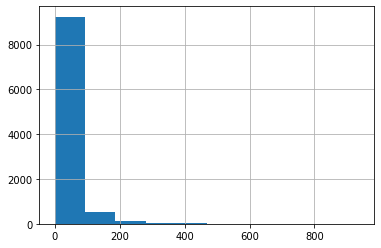

In [16]:
movies['Revenue'].hist()

Some scatter plots to see, how "Revenue", "Year" and "Score" behave: 

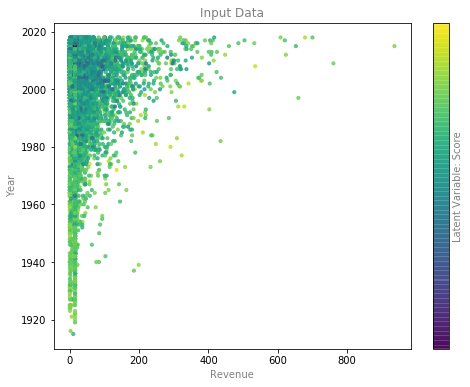

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
point_style = dict(cmap='Paired', s=50)
pts = ax.scatter(movies['Revenue'], movies['Year'], 
                 c=movies['Score'], s=10, alpha=0.8)
cb = fig.colorbar(pts, ax=ax)

# format plot
format_plot(ax, 'Input Data', 'Revenue', 'Year')
cb.set_ticks([])
cb.set_label('Latent Variable: Score', color='gray')

fig.savefig('images/movies/movies_revenue_year_score.png')

The Revenue increased during the years from 1920 to 2020. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FA3F86D908>,
      dtype=object)

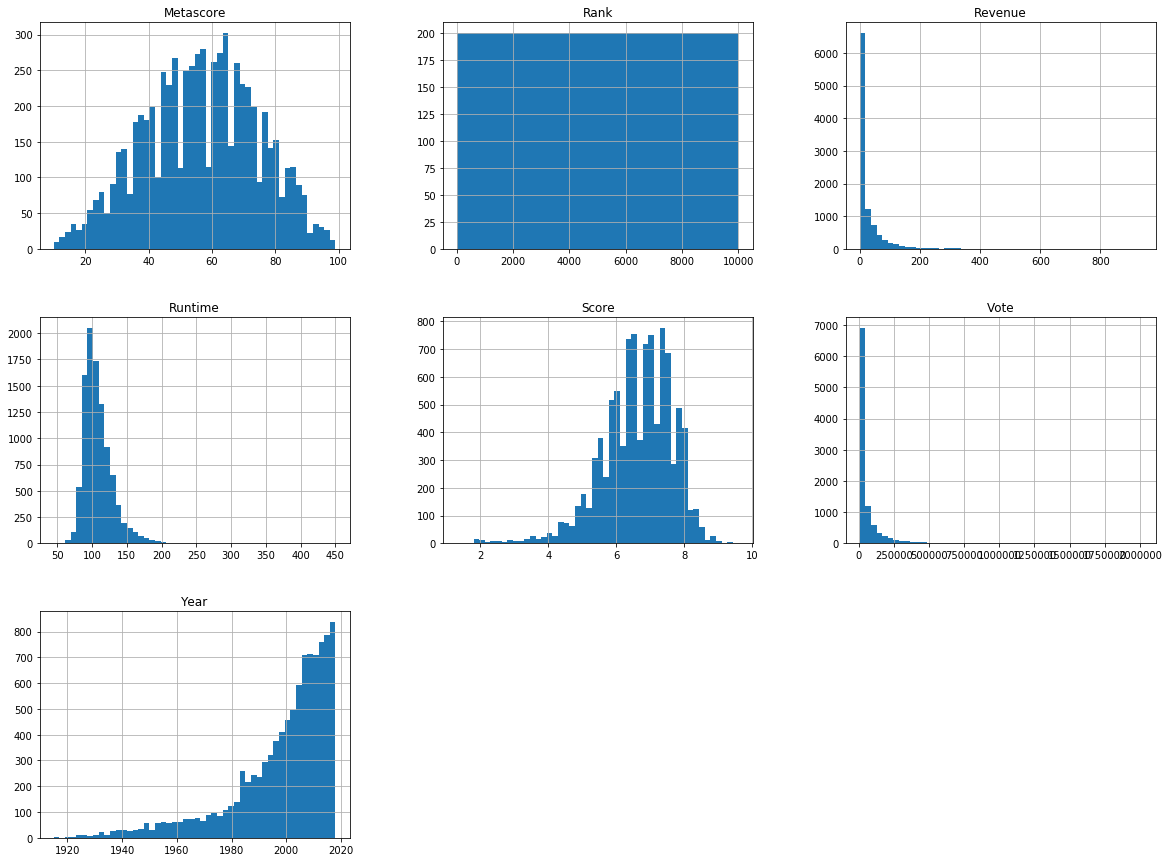

In [18]:
movies.hist(bins=50, figsize=(20,15))

As the "Rank" is a continuous ascending index, the histogramm looks like an rectangle. 
The "Runtime" of an average movie is about 100 minutes, which makes sense. 
The shape of the "Revenue" histogramm also seems so make sense. 
The "Metascore" and "Score" have some interesting jags, which is due to the discrete values (1,2,3... but not 1.24 or 3.73), which these values can take. 

Examine how "Year", "Score" and "Revenue" behave: 

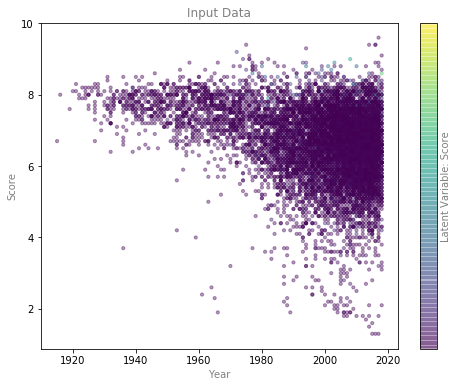

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
point_style = dict(cmap='Paired', s=50)
pts = ax.scatter(movies['Year'], movies['Score'], c=movies['Revenue'], s=10, alpha=0.4)
cb = fig.colorbar(pts, ax=ax)

# format plot
format_plot(ax, 'Input Data', 'Year', 'Score')
cb.set_ticks([])
cb.set_label('Latent Variable: Score', color='gray')

fig.savefig('images/movies/movies_year_score_revenue.png')

In 1920 most movies hat a score of 8. In 2020 most movies had a score between about 4 and 9. I think this is a bit strange, because I would have expected, that there are also movies with a lower score in 1920. 

# Stratified Sample

I want to draw a stratified sample with 4 buckets:

In [20]:
movies['RevCat']=pd.cut(movies['Revenue'], 
                        bins=[-1,100,200,300,np.inf], 
                        labels=[1, 2, 3, 4])
movies['RevCat'].value_counts()

1    9280
2     522
3     120
4      78
Name: RevCat, dtype: int64

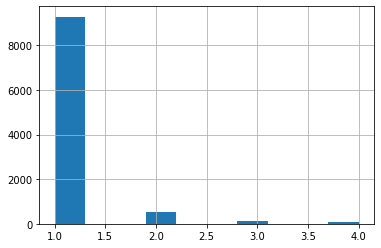

In [21]:
movies['RevCat'].hist()

In [22]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=42)
for train_index, test_index in split.split(movies, movies["RevCat"]):
    strat_train_set = movies.loc[train_index]
    strat_test_set = movies.loc[test_index]

Examine, if each bucket in the stratified sample has the same quotient of datarows as the original movies-dataset:

In [23]:
strat_test_set["RevCat"].value_counts() / len(strat_test_set)

1    0.928000
2    0.052222
3    0.012000
4    0.007778
Name: RevCat, dtype: float64

In [24]:
movies["RevCat"].value_counts() / len(movies)

1    0.9280
2    0.0522
3    0.0120
4    0.0078
Name: RevCat, dtype: float64

Examine in detail how "good" every bucket is: 

In [25]:
def revenue_cat_proportions(data):
    return data["RevCat"].value_counts() / len(data)

train_set, test_set = train_test_split(movies, test_size=0.9, random_state=42)

compare_props = pd.DataFrame({
    "Overall": revenue_cat_proportions(movies),
    "Stratified": revenue_cat_proportions(strat_test_set),
    "Random": revenue_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

print(compare_props)

for set_ in (strat_train_set, strat_test_set):
    set_.drop("RevCat", axis=1, inplace=True)

   Overall  Stratified    Random  Rand. %error  Strat. %error
1   0.9280    0.928000  0.927778     -0.023946   1.421085e-14
2   0.0522    0.052222  0.052333      0.255428   4.257131e-02
3   0.0120    0.012000  0.012111      0.925926   0.000000e+00
4   0.0078    0.007778  0.007778     -0.284900  -2.849003e-01


We have successfully splittet the movies-database in a training-database "strat_train_set" and a testing-database "strat_test_set":

In [26]:
strat_train_set

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description
6477,6478,Jeepers Creepers 3,2017,4.1,NaN,"Action, Horror, Mystery",13281,Victor Salva,100,2.24,Sheriff Dan Tashtego and a team of creeper hun...
973,974,The Blues Brothers,1980,7.9,60.0,"Adventure, Comedy, Crime",162642,John Landis,133,57.23,"Jake Blues, just out from prison, puts togethe..."
917,918,Sleepers,1996,7.6,49.0,"Crime, Drama, Thriller",171241,Barry Levinson,147,49.10,"After a prank goes disastrously wrong, a group..."
5710,5711,Hidden,2015,6.4,NaN,"Horror, Thriller",16805,Matt Duffer,84,15.09,A family takes refuge in a bomb shelter to avo...
9989,9990,The Narrow Margin,1952,7.7,NaN,"FilmNoir, Thriller",6031,Richard Fleischer,71,15.09,A woman planning to testify against the mob mu...
...,...,...,...,...,...,...,...,...,...,...,...
5143,5144,Friend Request,2016,5.3,31.0,"Horror, Thriller",20038,Simon Verhoeven,92,3.76,When a college student unfriends a mysterious ...
2986,2987,Night on Earth,1991,7.8,68.0,"Comedy, Drama",48129,Jim Jarmusch,129,2.02,An anthology of 5 different cab drivers in 5 A...
2057,2058,The Edge of Seventeen,2016,7.4,77.0,"Comedy, Drama",78059,Kelly Fremon Craig,104,14.26,High-school life gets even more unbearable for...
2258,2259,The Uninvited,2009,6.4,43.0,"Drama, Horror, Mystery",69928,Charles Guard,87,28.57,Anna returns home after a stint in a mental ho...


In [27]:
strat_test_set

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description
3921,3922,The Merchant of Venice,2004,7.1,63.0,"Drama, Romance",32418,Michael Radford,131,3.77,"In 16th century Venice, when a merchant must d..."
6943,6944,The Darkness,2016,4.4,27.0,"Horror, Thriller",11762,Greg McLean,92,10.73,A family unknowingly awakens an ancient supern...
9444,9445,Miyamoto Musashi,1954,7.6,NaN,"Action, Adventure, Biography",6657,Hiroshi Inagaki,93,15.09,Depicts the early life of the legendary warrio...
6446,6447,Maggie's Plan,2015,6.2,76.0,"Comedy, Drama, Romance",13405,Rebecca Miller,98,3.35,"Maggie wants to have a baby, raising him on he..."
1987,1988,For Your Eyes Only,1981,6.8,54.0,"Action, Adventure, Thriller",81338,John Glen,127,62.30,Agent 007 is assigned to hunt for a lost Briti...
...,...,...,...,...,...,...,...,...,...,...,...
9673,9674,Herbie Rides Again,1974,5.6,49.0,"Comedy, Family, Fantasy",6364,Robert Stevenson,88,38.23,The living Volkswagen Beetle helps an old lady...
7087,7088,The Bad and the Beautiful,1952,7.9,NaN,"Drama, Romance",11329,Vincente Minnelli,118,15.09,An unscrupulous movie producer uses an actress...
3397,3398,Perfect Blue,1997,7.9,NaN,"Animation, Horror, Mystery",40216,Satoshi Kon,81,0.44,A retired pop singer turned actress' sense of ...
4847,4848,Celebrity,1998,6.3,41.0,"Comedy, Drama",22416,Woody Allen,113,5.03,The fortunes of a husband and wife differ dras...


I want to predict the "Revenue" based on the other columns (year, score,...). Therfore I split the training set into the "movies_train" (the input variables) and the "movies_train_labels" (the value, which I want to predict: 

In [28]:
movies_train = strat_train_set.drop('Revenue', axis=1)
movies_train_labels = strat_train_set['Revenue'].copy()

In [29]:
movies_train

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Description
6477,6478,Jeepers Creepers 3,2017,4.1,NaN,"Action, Horror, Mystery",13281,Victor Salva,100,Sheriff Dan Tashtego and a team of creeper hun...
973,974,The Blues Brothers,1980,7.9,60.0,"Adventure, Comedy, Crime",162642,John Landis,133,"Jake Blues, just out from prison, puts togethe..."
917,918,Sleepers,1996,7.6,49.0,"Crime, Drama, Thriller",171241,Barry Levinson,147,"After a prank goes disastrously wrong, a group..."
5710,5711,Hidden,2015,6.4,NaN,"Horror, Thriller",16805,Matt Duffer,84,A family takes refuge in a bomb shelter to avo...
9989,9990,The Narrow Margin,1952,7.7,NaN,"FilmNoir, Thriller",6031,Richard Fleischer,71,A woman planning to testify against the mob mu...
...,...,...,...,...,...,...,...,...,...,...
5143,5144,Friend Request,2016,5.3,31.0,"Horror, Thriller",20038,Simon Verhoeven,92,When a college student unfriends a mysterious ...
2986,2987,Night on Earth,1991,7.8,68.0,"Comedy, Drama",48129,Jim Jarmusch,129,An anthology of 5 different cab drivers in 5 A...
2057,2058,The Edge of Seventeen,2016,7.4,77.0,"Comedy, Drama",78059,Kelly Fremon Craig,104,High-school life gets even more unbearable for...
2258,2259,The Uninvited,2009,6.4,43.0,"Drama, Horror, Mystery",69928,Charles Guard,87,Anna returns home after a stint in a mental ho...


In [30]:
movies_train_labels

6477     2.24
973     57.23
917     49.10
5710    15.09
9989    15.09
        ...  
5143     3.76
2986     2.02
2057    14.26
2258    28.57
5928    13.80
Name: Revenue, Length: 1000, dtype: float64

I do the same for the testing dataset: 

In [31]:
movies_test = strat_test_set.drop('Revenue', axis=1)
movies_test_labels = strat_test_set['Revenue'].copy()

In [32]:
movies_test

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Description
3921,3922,The Merchant of Venice,2004,7.1,63.0,"Drama, Romance",32418,Michael Radford,131,"In 16th century Venice, when a merchant must d..."
6943,6944,The Darkness,2016,4.4,27.0,"Horror, Thriller",11762,Greg McLean,92,A family unknowingly awakens an ancient supern...
9444,9445,Miyamoto Musashi,1954,7.6,NaN,"Action, Adventure, Biography",6657,Hiroshi Inagaki,93,Depicts the early life of the legendary warrio...
6446,6447,Maggie's Plan,2015,6.2,76.0,"Comedy, Drama, Romance",13405,Rebecca Miller,98,"Maggie wants to have a baby, raising him on he..."
1987,1988,For Your Eyes Only,1981,6.8,54.0,"Action, Adventure, Thriller",81338,John Glen,127,Agent 007 is assigned to hunt for a lost Briti...
...,...,...,...,...,...,...,...,...,...,...
9673,9674,Herbie Rides Again,1974,5.6,49.0,"Comedy, Family, Fantasy",6364,Robert Stevenson,88,The living Volkswagen Beetle helps an old lady...
7087,7088,The Bad and the Beautiful,1952,7.9,NaN,"Drama, Romance",11329,Vincente Minnelli,118,An unscrupulous movie producer uses an actress...
3397,3398,Perfect Blue,1997,7.9,NaN,"Animation, Horror, Mystery",40216,Satoshi Kon,81,A retired pop singer turned actress' sense of ...
4847,4848,Celebrity,1998,6.3,41.0,"Comedy, Drama",22416,Woody Allen,113,The fortunes of a husband and wife differ dras...


In [33]:
movies_test_labels

3921     3.77
6943    10.73
9444    15.09
6446     3.35
1987    62.30
        ...  
9673    38.23
7087    15.09
3397     0.44
4847     5.03
6489    22.29
Name: Revenue, Length: 9000, dtype: float64

The whole dataset of 10000 rows has been split up into a training dataset ("movies_train") with 1000 rows and a testing dataset ("movies_test") with 9000 rows. 

# Pipeline

Now I want to implement a pipeline for doing all the datapreparation work quicker when I am testing it later. Only numerical-columns will be taken. The other will be thrown away (for the moment, I will change this later): 

In [34]:
imputer = SimpleImputer(strategy="median")
movies_train_num = movies_train.select_dtypes(include=[np.number])
imputer.fit(movies_train_num)
X = imputer.transform(movies_train_num) # Transform the training set:
movies_tr = pd.DataFrame(X, columns=movies_train_num.columns,index=movies_train.index)
movies_tr

,Rank,Year,Score,Metascore,Vote,Runtime
6477,6478.0,2017.0,4.1,56.0,13281.0,100.0
973,974.0,1980.0,7.9,60.0,162642.0,133.0
917,918.0,1996.0,7.6,49.0,171241.0,147.0
5710,5711.0,2015.0,6.4,56.0,16805.0,84.0
9989,9990.0,1952.0,7.7,56.0,6031.0,71.0
...,...,...,...,...,...,...
5143,5144.0,2016.0,5.3,31.0,20038.0,92.0
2986,2987.0,1991.0,7.8,68.0,48129.0,129.0
2057,2058.0,2016.0,7.4,77.0,78059.0,104.0
2258,2259.0,2009.0,6.4,43.0,69928.0,87.0


In [35]:
num_attribs = list(movies_train_num)
num_attribs

['Rank', 'Year', 'Score', 'Metascore', 'Vote', 'Runtime']

In [36]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
])

num_attribs = ['Rank', 'Year', 'Score', 'Metascore', 'Vote', 'Runtime'] #list(movies_train_num)

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs)
])

Apply now the full pipeline on the training-dataset "movies_train". But before we do this, we have a look into the column "Metascore" and count how many "nan"-values we have there in the training dataset "movies_train": 

In [37]:
tmp = movies_train[movies_train["Metascore"].isnull()]
tmp

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Description
6477,6478,Jeepers Creepers 3,2017,4.1,NaN,"Action, Horror, Mystery",13281,Victor Salva,100,Sheriff Dan Tashtego and a team of creeper hun...
5710,5711,Hidden,2015,6.4,NaN,"Horror, Thriller",16805,Matt Duffer,84,A family takes refuge in a bomb shelter to avo...
9989,9990,The Narrow Margin,1952,7.7,NaN,"FilmNoir, Thriller",6031,Richard Fleischer,71,A woman planning to testify against the mob mu...
9306,9307,Arthur 3: la guerre des deux mondes,2010,5.5,NaN,"Animation, Adventure, Family",6841,Luc Besson,101,With Maltazard now seven feet tall and Arthur ...
8437,8438,Troll,1986,4.4,NaN,"Comedy, Fantasy, Horror",8105,John Carl Buechler,82,A wicked troll king in search of a mystical ri...
...,...,...,...,...,...,...,...,...,...,...
5922,5923,Catch .44,2011,4.6,NaN,"Action, Crime, Drama",15737,Aaron Harvey,94,For Tes (Akerman) and her two cohorts Kara (Ni...
9720,9721,Hababam Sinifi Üç Buçuk,2005,2.8,NaN,"Comedy, Thriller",6300,Ferdi Egilmez,98,Hababam Sinifi returns to the nest finished hi...
7284,7285,Elvira: Mistress of the Dark,1988,6.5,NaN,"Comedy, Horror",10807,James Signorelli,96,Upon arriving in a small town where she has in...
8966,8967,The Front,1976,7.4,NaN,Drama,7276,Martin Ritt,95,"In 1953, a cashier poses as a writer for black..."


Remember: we had in total "count_nan_values_in_col_Metascore" rows with "nan"-values in the column "Metascore". Now, after the split of the whole dataset "movies" into the two datasets "movies_train" and "movies_test", some of these "nan"-values are in the dataset "movies_train" and some in the dataset "movies_test". It is not important for general machine-learning procedures to know how many are in each of these two datasets. But in order to make it clearer, what happens here, I will show it in detail. 

The rows with "nan-values" in the testing dataset "movies_test": 

In [38]:
tmp = movies_test[movies_test["Metascore"].isnull()]
tmp

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Description
9444,9445,Miyamoto Musashi,1954,7.6,NaN,"Action, Adventure, Biography",6657,Hiroshi Inagaki,93,Depicts the early life of the legendary warrio...
1914,1915,Small Soldiers,1998,6.1,NaN,"Action, Adventure, Comedy",84345,Joe Dante,108,When missile technology is used to enhance toy...
6602,6603,Lootera,2013,7.3,NaN,"Drama, Romance",12826,Vikramaditya Motwane,136,An aristocrat's daughter falls in love with a ...
7223,7224,Stage Fright,1950,7.1,NaN,"FilmNoir, Thriller",10987,Alfred Hitchcock,110,A struggling actress tries to help a friend pr...
4691,4692,White Heat,1949,8.2,NaN,"Action, Crime, Drama",23733,Raoul Walsh,114,A psychopathic criminal with a mother complex ...
...,...,...,...,...,...,...,...,...,...,...
8566,8567,Avenging Angelo,2002,5.2,NaN,"Action, Comedy, Crime",7870,Martyn Burke,97,A woman who has just discovered she is the dau...
5821,5822,Chocolate,2008,7.0,NaN,"Action, Drama",16220,Prachya Pinkaew,92,An autistic girl with powerful martial art ski...
8509,8510,The Hound of the Baskervilles,1959,7.0,NaN,"Horror, Mystery",7976,Terence Fisher,87,When a nobleman is threatened by a family curs...
7087,7088,The Bad and the Beautiful,1952,7.9,NaN,"Drama, Romance",11329,Vincente Minnelli,118,An unscrupulous movie producer uses an actress...


In [39]:
315+2904

3219

In [40]:
count_nan_values_in_col_Metascore

3219

Which shows, that all "nan" vlaues in columns "Metascore" are still there. They simply have been split up to the two dataset movies_train and movies_test. 

Now apply the Pipeline:

In [41]:
movies_train_prepared = full_pipeline.fit_transform(movies_train)

Now let's count the "nan" values in the new prepared datast "movies_train_prepared". I have to transform it back to a Pandas-Dataframe format first: 

In [42]:
tmp_num = movies_train.select_dtypes(include=[np.number])
tmp_prep = pd.DataFrame(movies_train_prepared, columns=tmp_num.columns,index=movies_train.index)
tmp = tmp_prep[tmp_prep["Metascore"].isnull()]
tmp

,Rank,Year,Score,Metascore,Vote,Runtime


Zero, as we wanted! All "nan"-values in "movies_train_prepared" have been removed by the "median" value (this was how the pipeline was built). Great, this was part of the job, the Pipline should have done.  The other part was to eliminate some columns. We now have only 6 remaining instead of 10 columns. 

# Model "DecisionTreeRegressor"

In [43]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(movies_train_prepared, movies_train_labels)

movies_predictions = tree_reg.predict(movies_train_prepared)

Verifiy if training labels ("movies_train_labels") and predicted labels ("movies_predictions"). Here for the first 10 datasets:

In [44]:
movies_train_labels[0:10]

6477      2.24
973      57.23
917      49.10
5710     15.09
9989     15.09
1339    113.72
9306     15.09
8437      5.45
7206     15.09
8879     15.09
Name: Revenue, dtype: float64

In [45]:
movies_predictions[0:10]

array([  2.24,  57.23,  49.1 ,  15.09,  15.09, 113.72,  15.09,   5.45,
        15.09,  15.09])

The training-labels and the predicted labels match for the first 10 datasets. The fitting of the model was successful.

How big is the error for all training-datasets?

In [46]:
trainmse = mean_squared_error(movies_train_labels, movies_predictions)
trainrmse = np.sqrt(trainmse)
trainrmse

1.639645682759909e-15

# Cross-Validation

In [47]:
scores = cross_val_score(tree_reg, 
                         movies_train_prepared,
                         movies_train_labels,
                         scoring="neg_mean_squared_error", 
                         cv=10)

rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rmse_scores)

Scores: [62.34519099 60.94806391 44.26072028 79.13906687 38.66371683 37.44365142
 43.06232959 50.49908359 53.07987995 68.63761368]
Mean: 53.80793171223163
Standard deviation: 13.041030708951544


# Test the model

We take on arbitrary row in the testing dataset "movies_test". Take for example row number 322:

In [48]:
some_data = movies_test.iloc[0:20]
some_data_label = movies_test_labels.iloc[0:20]

In [49]:
some_data

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Description
3921,3922,The Merchant of Venice,2004,7.1,63.0,"Drama, Romance",32418,Michael Radford,131,"In 16th century Venice, when a merchant must d..."
6943,6944,The Darkness,2016,4.4,27.0,"Horror, Thriller",11762,Greg McLean,92,A family unknowingly awakens an ancient supern...
9444,9445,Miyamoto Musashi,1954,7.6,NaN,"Action, Adventure, Biography",6657,Hiroshi Inagaki,93,Depicts the early life of the legendary warrio...
6446,6447,Maggie's Plan,2015,6.2,76.0,"Comedy, Drama, Romance",13405,Rebecca Miller,98,"Maggie wants to have a baby, raising him on he..."
1987,1988,For Your Eyes Only,1981,6.8,54.0,"Action, Adventure, Thriller",81338,John Glen,127,Agent 007 is assigned to hunt for a lost Briti...
1914,1915,Small Soldiers,1998,6.1,NaN,"Action, Adventure, Comedy",84345,Joe Dante,108,When missile technology is used to enhance toy...
4184,4185,Mustang,2015,7.6,83.0,Drama,29094,Deniz Gamze Ergüven,97,When five orphan girls are seen innocently pla...
9433,9434,Skin Trade,2014,5.7,39.0,"Action, Crime, Thriller",6668,Ekachai Uekrongtham,96,After his family is killed by a Serbian gangst...
6602,6603,Lootera,2013,7.3,NaN,"Drama, Romance",12826,Vikramaditya Motwane,136,An aristocrat's daughter falls in love with a ...
3618,3619,All About Steve,2009,4.8,17.0,"Comedy, Romance",36605,Phil Traill,99,Convinced that a CCN cameraman is her true lov...


As we didn't apply the pipeline on the testing dataset (we only did on the training dataset "movies_train"), there are still some "nan" values in columns "Metascore".

The true value for the "Revenue" is: 

In [50]:
some_data_label

3921     3.77
6943    10.73
9444    15.09
6446     3.35
1987    62.30
1914    54.68
4184     0.85
9433     0.00
6602     0.38
3618    33.86
8493    17.95
3691    15.09
2684    16.31
7223    15.09
1307    37.02
4209     2.96
4383    19.17
4691    15.09
9670    15.09
6621     0.75
Name: Revenue, dtype: float64

This row is the same as the following dataset from the original "movies"-database:

In [51]:
some_movies = movies.iloc[some_data.index[0:len(some_data)]]
some_movies

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description,RevCat
3921,3922,The Merchant of Venice,2004,7.1,63.0,"Drama, Romance",32418,Michael Radford,131,3.77,"In 16th century Venice, when a merchant must d...",1
6943,6944,The Darkness,2016,4.4,27.0,"Horror, Thriller",11762,Greg McLean,92,10.73,A family unknowingly awakens an ancient supern...,1
9444,9445,Miyamoto Musashi,1954,7.6,NaN,"Action, Adventure, Biography",6657,Hiroshi Inagaki,93,15.09,Depicts the early life of the legendary warrio...,1
6446,6447,Maggie's Plan,2015,6.2,76.0,"Comedy, Drama, Romance",13405,Rebecca Miller,98,3.35,"Maggie wants to have a baby, raising him on he...",1
1987,1988,For Your Eyes Only,1981,6.8,54.0,"Action, Adventure, Thriller",81338,John Glen,127,62.30,Agent 007 is assigned to hunt for a lost Briti...,1
1914,1915,Small Soldiers,1998,6.1,NaN,"Action, Adventure, Comedy",84345,Joe Dante,108,54.68,When missile technology is used to enhance toy...,1
4184,4185,Mustang,2015,7.6,83.0,Drama,29094,Deniz Gamze Ergüven,97,0.85,When five orphan girls are seen innocently pla...,1
9433,9434,Skin Trade,2014,5.7,39.0,"Action, Crime, Thriller",6668,Ekachai Uekrongtham,96,0.00,After his family is killed by a Serbian gangst...,1
6602,6603,Lootera,2013,7.3,NaN,"Drama, Romance",12826,Vikramaditya Motwane,136,0.38,An aristocrat's daughter falls in love with a ...,1
3618,3619,All About Steve,2009,4.8,17.0,"Comedy, Romance",36605,Phil Traill,99,33.86,Convinced that a CCN cameraman is her true lov...,1


Lets predict the revenue for this dataset:

In [52]:
some_data_prepared = full_pipeline.fit_transform(some_data)
some_data_predictions = tree_reg.predict(some_data_prepared)
list(some_data_predictions)

[41.29,
 15.09,
 15.09,
 0.27,
 177.4,
 58.42,
 19.38,
 15.09,
 0.07,
 43.8,
 0.55,
 28.83,
 19.39,
 0.1,
 83.3,
 15.09,
 33.77,
 21.3,
 0.14,
 5.01]

Compare this prediction to the value "some_data_label". 

In [53]:
list(some_data_label)

[3.77,
 10.73,
 15.09,
 3.35,
 62.3,
 54.68,
 0.85,
 0.0,
 0.38,
 33.86,
 17.95,
 15.09,
 16.31,
 15.09,
 37.02,
 2.96,
 19.17,
 15.09,
 15.09,
 0.75]

Compare the true value ("some_data_labels") and the predicted value ("some_data_predicitons") side-by-side. Left side is the true value from the original movies dataset. Right side is the predicted value based on the tree model: 

In [54]:
side_by_side = [(true, pred) for true, pred in zip(list(some_data_label), list(some_data_predictions))]
side_by_side

[(3.77, 41.29),
 (10.73, 15.09),
 (15.09, 15.09),
 (3.35, 0.27),
 (62.3, 177.4),
 (54.68, 58.42),
 (0.85, 19.38),
 (0.0, 15.09),
 (0.38, 0.07),
 (33.86, 43.8),
 (17.95, 0.55),
 (15.09, 28.83),
 (16.31, 19.39),
 (15.09, 0.1),
 (37.02, 83.3),
 (2.96, 15.09),
 (19.17, 33.77),
 (15.09, 21.3),
 (15.09, 0.14),
 (0.75, 5.01)]

Some of the predictions are quiet close to the true value. But some are far away. 

Remember that we used the median-value for filling the "nan"-values in the column "Revenue" (which is our "label" in this project):

In [55]:
median_Rev

15.09

We see here, that there are rows, where this "median_Rev" has been used. 

In [56]:
some_movies[some_movies['Revenue']==median_Rev]


,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description,RevCat
9444,9445,Miyamoto Musashi,1954,7.6,NaN,"Action, Adventure, Biography",6657,Hiroshi Inagaki,93,15.09,Depicts the early life of the legendary warrio...,1
3691,3692,Holy Motors,2012,7.1,84.0,"Drama, Fantasy",35588,Leos Carax,115,15.09,"From dawn to dusk, a few hours in the shadowy ...",1
7223,7224,Stage Fright,1950,7.1,NaN,"FilmNoir, Thriller",10987,Alfred Hitchcock,110,15.09,A struggling actress tries to help a friend pr...,1
4691,4692,White Heat,1949,8.2,NaN,"Action, Crime, Drama",23733,Raoul Walsh,114,15.09,A psychopathic criminal with a mother complex ...,1
9670,9671,Dolan's Cadillac,2009,5.7,NaN,"Crime, Thriller",6372,Jeff Beesley,89,15.09,A young man attempts to seek to avenge his wif...,1


These are un-prepared data (pipline has not been applied). Therefore we wee "Metascore" with "nan"-values. 

For the prediction the pipline has been applied. The predicion for these rows is as follows:

In [57]:
[(true, pred) for true, pred in side_by_side if true==median_Rev]

[(15.09, 15.09), (15.09, 28.83), (15.09, 0.1), (15.09, 21.3), (15.09, 0.14)]

Maybe I should re-think about the "median" assumption for filling "nan"-values in the "Revenue" column, because the movie from 1920 have probably a lower median-Revenue than the movies in 2020. Therefor filling with the median, which was valid in the specific year instaed of filling with the median of the whole movies-dataset would have made more sense. 

The mean-squared-error is as follows: 

In [58]:
mse = mean_squared_error(some_data_label, some_data_predictions)
rmse = np.sqrt(mse)
rmse

30.72156921447861

Taking now the whole testing dataset: 

In [59]:
movies_test_prepared =full_pipeline.fit_transform(movies_test)
movies_test_predictions = tree_reg.predict(movies_test_prepared)
lin_mse = mean_squared_error(movies_test_labels, movies_test_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

50.401716569974084

In [60]:
movies_test_labels.mean()

30.85265888888852

In [61]:
movies_test_labels.std()

53.092436441737476

A side-by-side comparison off the testing dataset. Left side is the true value from the original movies dataset. Right side is the predicted value based on the tree model: 

In [62]:
side_by_side = [(true, pred) for true, pred in zip(list(movies_test_labels), list(movies_test_predictions))]
side_by_side

[(3.77, 41.29),
 (10.73, 15.09),
 (15.09, 15.09),
 (3.35, 0.27),
 (62.3, 177.4),
 (54.68, 58.42),
 (0.85, 19.38),
 (0.0, 15.09),
 (0.38, 3.41),
 (33.86, 43.8),
 (17.95, 0.55),
 (15.09, 28.83),
 (16.31, 19.39),
 (15.09, 0.1),
 (37.02, 83.3),
 (2.96, 15.09),
 (19.17, 33.77),
 (15.09, 21.3),
 (15.09, 2.07),
 (0.75, 5.01),
 (15.09, 0.1),
 (8.12, 15.09),
 (3.92, 13.09),
 (7.02, 1.33),
 (12.71, 83.3),
 (15.09, 15.09),
 (45.01, 52.93),
 (0.33, 15.09),
 (8.14, 10.18),
 (42.48, 56.25),
 (56.57, 63.27),
 (0.1, 3.61),
 (12.59, 15.089999999999998),
 (93.62, 107.83),
 (0.05, 12.9),
 (15.09, 15.089999999999998),
 (5.89, 15.09),
 (20.41, 15.09),
 (15.09, 156.45),
 (15.09, 0.06),
 (13.47, 15.090000000000002),
 (43.88, 13.09),
 (36.02, 47.81),
 (34.74, 15.09),
 (59.89, 54.58),
 (153.71, 18.32),
 (15.09, 15.09),
 (8.01, 2.66),
 (2.1, 2.38),
 (0.03, 0.59),
 (32.62, 23.83),
 (0.03, 15.09),
 (40.07, 83.3),
 (15.09, 2.66),
 (15.09, 0.1),
 (15.09, 0.1),
 (16.25, 65.0),
 (38.91, 38.23),
 (0.07, 0.21),
 (15.09

Plotting the true labels and the predicted labels on the testing dataset: 

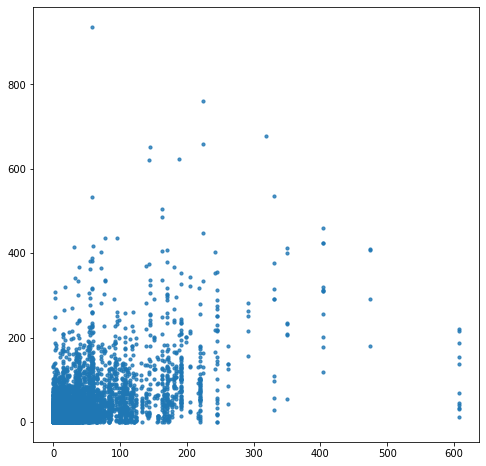

In [63]:
fig, ax = plt.subplots(figsize=(8, 8))
pts = ax.scatter(movies_test_predictions, movies_test_labels, s=10, alpha=0.8)

Looks confusing. I would have expected something a bit more similar to the following plot.

Plotting the same for the training data: 

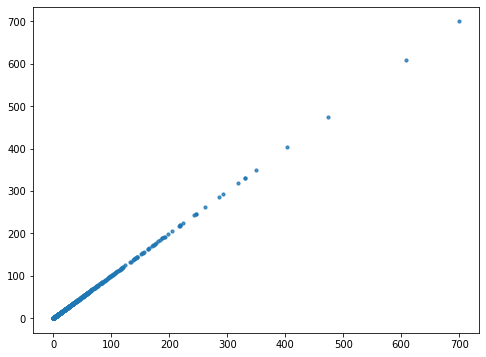

In [64]:
movies_train_prepared =full_pipeline.fit_transform(movies_train)
movies_train_predictions = tree_reg.predict(movies_train_prepared)
fig, ax = plt.subplots(figsize=(8, 6))
pts = ax.scatter(movies_train_predictions, movies_train_labels, s=10, alpha=0.8)

# Future amendments

The movies dataset has the following columns (including "Revenue" which I wanted to predict):

In [65]:
movies.head(0)

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description,RevCat


But the model is only taking the follwing columns into consideration: 

In [66]:
num_attribs

['Rank', 'Year', 'Score', 'Metascore', 'Vote', 'Runtime']

Remember, that the dataset, which is used for the model looks as follows (all non-numeric columns disappeared): 

In [67]:
movies_tr

,Rank,Year,Score,Metascore,Vote,Runtime
6477,6478.0,2017.0,4.1,56.0,13281.0,100.0
973,974.0,1980.0,7.9,60.0,162642.0,133.0
917,918.0,1996.0,7.6,49.0,171241.0,147.0
5710,5711.0,2015.0,6.4,56.0,16805.0,84.0
9989,9990.0,1952.0,7.7,56.0,6031.0,71.0
...,...,...,...,...,...,...
5143,5144.0,2016.0,5.3,31.0,20038.0,92.0
2986,2987.0,1991.0,7.8,68.0,48129.0,129.0
2057,2058.0,2016.0,7.4,77.0,78059.0,104.0
2258,2259.0,2009.0,6.4,43.0,69928.0,87.0


Therefore lot's of information, which is in the dataset has not yet been used, e.g. "Genre", "Director". These information could have an positive impact on the correctness of the predictions.  

But as "Genre" has 486 different values it is a bit more complicated to treat them as "categorial" values:

In [68]:
movies['Genre'].value_counts()

Comedy, Drama, Romance           494
Drama                            482
Comedy, Drama                    407
Drama, Romance                   365
Comedy                           357
                                ... 
Adventure, Crime                   1
Crime, FilmNoir, Sport             1
Crime                              1
Animation, Fantasy, Adventure      1
Musical, Comedy, Romance           1
Name: Genre, Length: 486, dtype: int64

As already mentionned right in the beginning of this Jupyter-Notebook the "OneHotEncoder" could be used. But before we should work on these 486 categorial values: could we simplify it, e.g. extract "Drama" and use it as a separate criteria? I will do this in another notebook. 